In [1]:
import pandas as pd 

In [2]:
train_data = pd.read_csv('IMDB Dataset.csv')

In [3]:
train_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
sentiment_replace = {'positive': 1, 'negative':0}
train_data['sentiment'] = train_data['sentiment'].map(sentiment_replace)
train_data['sentiment'].unique()

array([1, 0])

Text(0.5, 1.0, 'Sentiment Distribution in Training Data ')

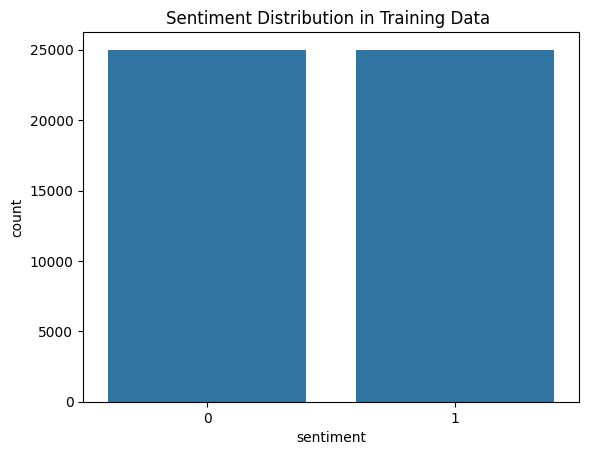

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.countplot(x = 'sentiment' ,data = train_data )
plt.title("Sentiment Distribution in Training Data ")

In [52]:
import re 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

import nltk 

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/toygunozyurek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/toygunozyurek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/toygunozyurek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [53]:
def preprocess_text(text): 
    text = re.sub(r'<.*?>','',text)
    text  = re.sub(r'http\S+|www\S+|@\S+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

train_data['cleaned_text'] = train_data['review'].apply(preprocess_text)

In [54]:
train_data.head()

,review,sentiment,cleaned_text
0,One of the other reviewers has mentioned that ...,1,One reviewer mentioned watching Oz episode you...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,Basically there family little boy Jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,Petter Matteis Love Time Money visually stunni...


In [55]:
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test, y_train, y_test = train_test_split(train_data['cleaned_text'], train_data['sentiment'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': MultinomialNB()
}

In [57]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_tfidf, y_train)
logistic_pred = logistic_model.predict(X_test_tfidf)
logistic_accuracy = accuracy_score(y_test, logistic_pred)
print(f'Logistic Regression Accuracy: {logistic_accuracy}')
print('Classification Report for Logistic Regression:')
print(classification_report(y_test, logistic_pred))

Logistic Regression Accuracy: 0.8862
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [58]:
# Support Vector Machine
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f'Support Vector Machine Accuracy: {svm_accuracy}')
print('Classification Report for Support Vector Machine:')
print(classification_report(y_test, svm_pred))

Support Vector Machine Accuracy: 0.8891
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [59]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
rf_pred = rf_model.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f'Random Forest Accuracy: {rf_accuracy}')
print('Classification Report for Random Forest:')
print(classification_report(y_test, rf_pred))

Random Forest Accuracy: 0.8478
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      4961
           1       0.86      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [60]:
# Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_tfidf, y_train)
gb_pred = gb_model.predict(X_test_tfidf)
gb_accuracy = accuracy_score(y_test, gb_pred)
print(f'Gradient Boosting Accuracy: {gb_accuracy}')
print('Classification Report for Gradient Boosting:')
print(classification_report(y_test, gb_pred))

Gradient Boosting Accuracy: 0.8084
Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.84      0.75      0.80      4961
           1       0.78      0.86      0.82      5039

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [61]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_pred = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_pred)
print(f'Naive Bayes Accuracy: {nb_accuracy}')
print('Classification Report for Naive Bayes:')
print(classification_report(y_test, nb_pred))

Naive Bayes Accuracy: 0.8492
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [62]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['cleaned_text'])
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=500)
X_test_pad = pad_sequences(X_test_seq, maxlen=500)

In [63]:
# LSTM Model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=500))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Epoch 1/5
625/625 [==============================] - 486s 778ms/step - loss: 0.3583 - accuracy: 0.8433 - val_loss: 0.2918 - val_accuracy: 0.8793
Epoch 2/5
625/625 [==============================] - 496s 794ms/step - loss: 0.2579 - accuracy: 0.8974 - val_loss: 0.2799 - val_accuracy: 0.8814
Epoch 3/5
625/625 [==============================] - 481s 770ms/step - loss: 0.2216 - accuracy: 0.9147 - val_loss: 0.2893 - val_accuracy: 0.8802
Epoch 4/5
625/625 [==============================] - 492s 786ms/step - loss: 0.1925 - accuracy: 0.9251 - val_loss: 0.3120 - val_accuracy: 0.8752
Epoch 5/5
625/625 [==============================] - 493s 790ms/step - loss: 0.2021 - accuracy: 0.9218 - val_loss: 0.3370 - val_accuracy: 0.8776
LSTM Test Accuracy: 0.8776000142097473


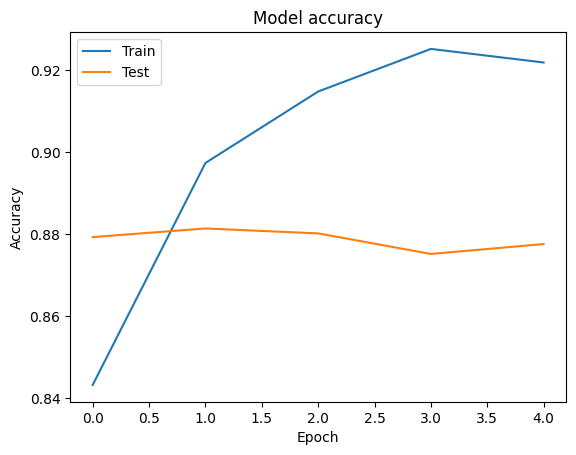

In [64]:
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test), verbose=1)

# Evaluate the model
score = model.evaluate(X_test_pad, y_test, verbose=0)
print("LSTM Test Accuracy:", score[1])

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

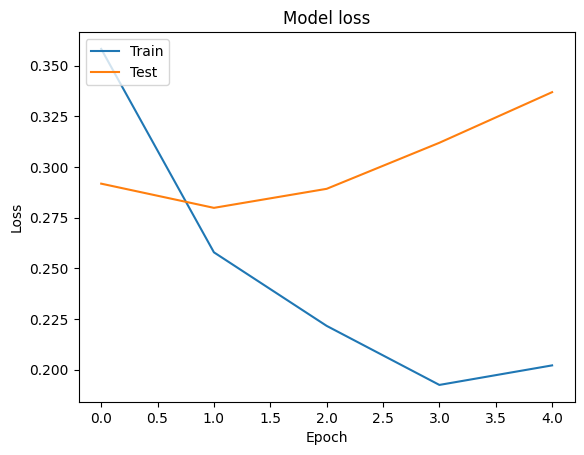

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()